# <span style="color: darkblue;">E-commerce Product Recommendation Chatbot with RAG: Leveraging Amazon Electronics Reviews</span>

## <span style="color: purple;">Introduction</span>
<p>This notebook implements an <span style="color: teal;">E-commerce Product Recommendation Chatbot</span> using <span style="color: orange;">Retrieval-Augmented Generation (RAG)</span>, a <span style="color: green;">powerful approach</span> that combines information retrieval with natural language generation. The chatbot assists users in finding <span style="color: blue;">electronics products</span>, such as <span style="color: navy;">laptops</span>, based on preferences like <span style="color: red;">price</span>, <span style="color: red;">rating</span>, and features (e.g., <span style="color: brown;">durability</span>). We utilize the <span style="color: gold;">"Amazon US Customer Reviews Dataset"</span> from Kaggle, specifically the <span style="color: goldenrod;">Electronics subset</span>, to provide <span style="color: pink;">real-world product data and reviews</span>. Built with <span style="color: darkgreen;">Python</span>, <span style="color: darkcyan;">LangChain</span>, <span style="color: darkcyan;">FAISS</span>, and <span style="color: darkcyan;">Hugging Face transformers</span>, this project demonstrates how <span style="color: violet;">AI</span> can enhance online shopping experiences by delivering <span style="color: magenta;">personalized, context-aware recommendations</span>.</p>

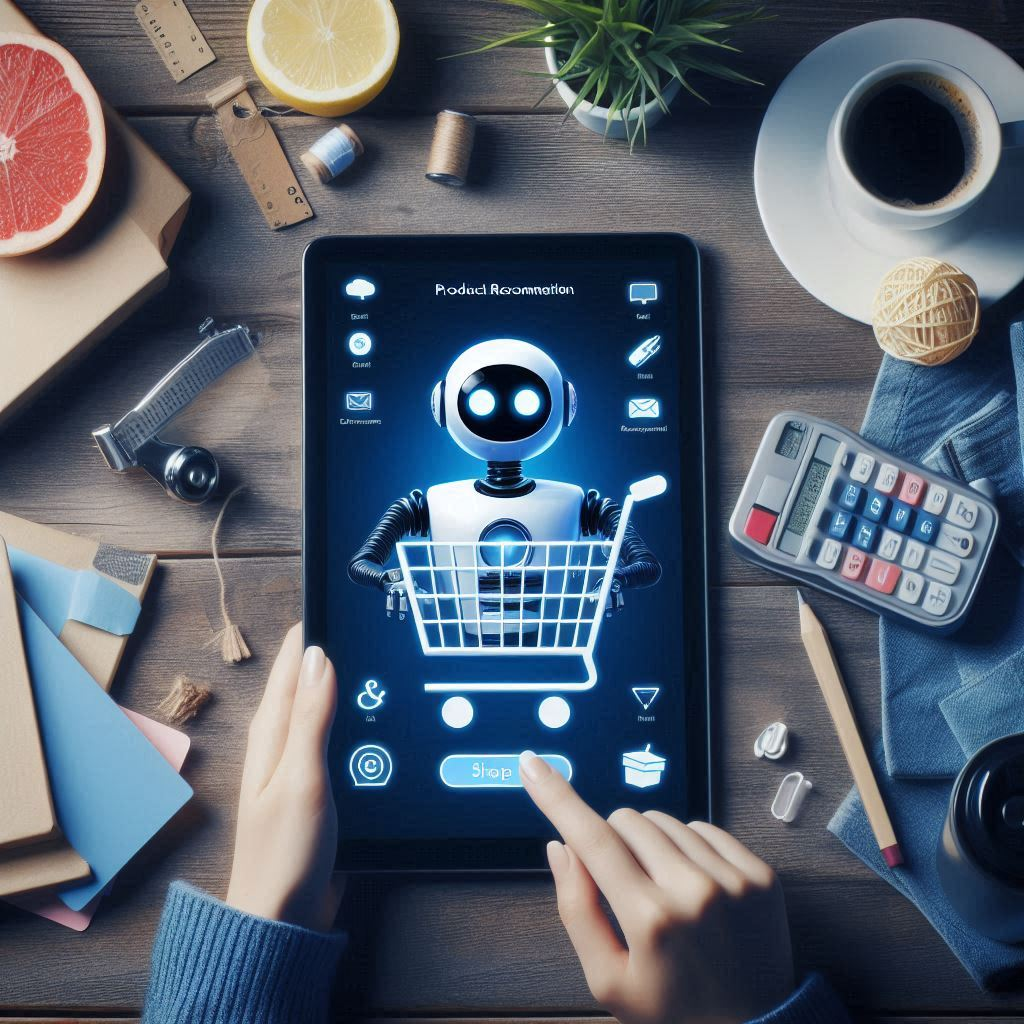

# <span style="color: darkblue;">Setup Environment</span>

In [1]:
# Install required libraries
!pip install langchain langchain-community faiss-cpu sentence-transformers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 55.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 57.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.4/423.4 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: async-timeout
    Found existing installation: async-timeout 5.0.1
    Uninstalling async-timeout-5.0.1:
      Successfully uninstalled async-timeout-5.0.1
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.3
    Uninstalling langchain-text-splitters-0.3.3:
      Successfully uninstalled langchain-text-splitters-0.3.3
  Attempting uninstall: langchain
    Found existing installation: langchain 0

# <span style="color: darkblue;">Import Libraries</span>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline
import os
import warnings
warnings.filterwarnings("ignore")

# <span style="color: darkblue;">Load and Overview of the Dataset</span>

In [3]:
# Define the path to the specific TSV file
dataset_path = "/kaggle/input/amazon-us-customer-reviews-dataset/amazon_reviews_us_Electronics_v1_00.tsv"

# Verify the file exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"File not found at {dataset_path}. Please ensure the dataset is correctly attached.")

# Load the TSV dataset (using tab separator)
df = pd.read_csv(dataset_path, sep='\t', on_bad_lines='skip')  # 'skip' handles malformed lines

# Select relevant columns
df = df[['product_id', 'product_title', 'star_rating', 'review_body']].dropna()

# Add mock price since it's not in the dataset
df['price'] = np.random.randint(50, 1500, size=len(df))

# Use a subset for EDA and processing (e.g., 1000 rows)
df = df.head(1000)
print("Dataset shape:", df.shape)

Dataset shape: (1000, 5)


# <span style="color: darkblue;">Exploratory Data Analysis (EDA)</span>

Let’s explore the dataset to understand its characteristics.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     1000 non-null   object
 1   product_title  1000 non-null   object
 2   star_rating    1000 non-null   int64 
 3   review_body    1000 non-null   object
 4   price          1000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 46.9+ KB
None

Summary Statistics:
       star_rating       price
count  1000.000000  1000.00000
mean      4.115000   766.20100
std       1.414134   427.19968
min       1.000000    51.00000
25%       4.000000   391.00000
50%       5.000000   776.00000
75%       5.000000  1133.25000
max       5.000000  1498.00000


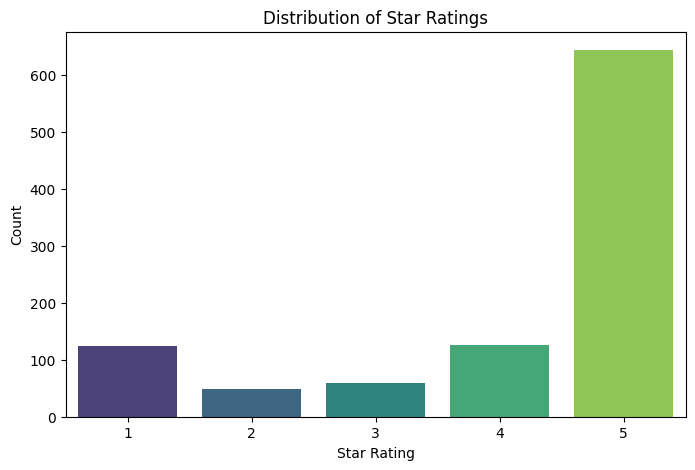

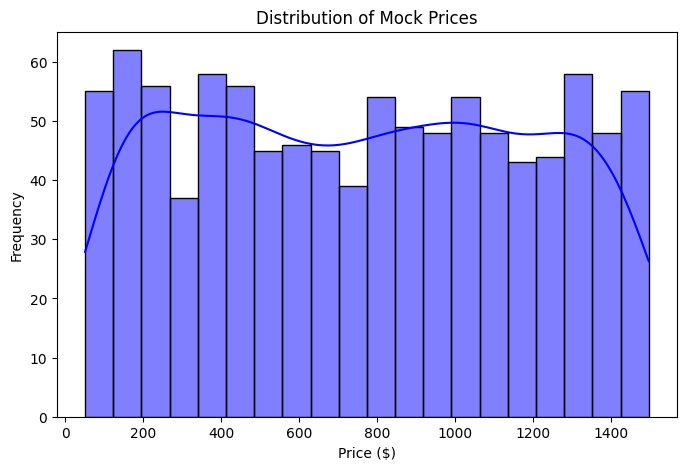

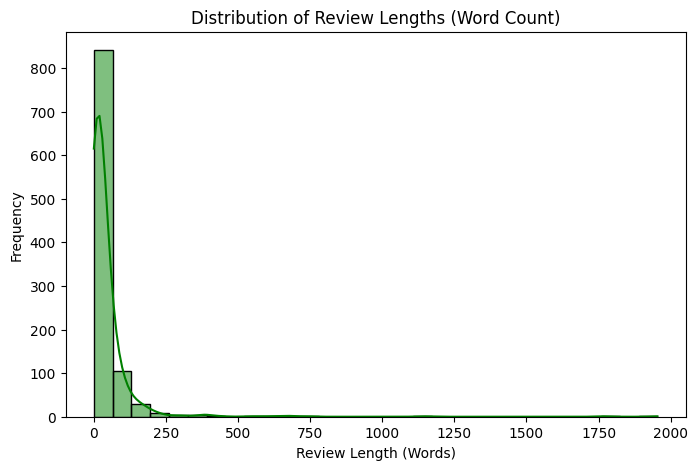

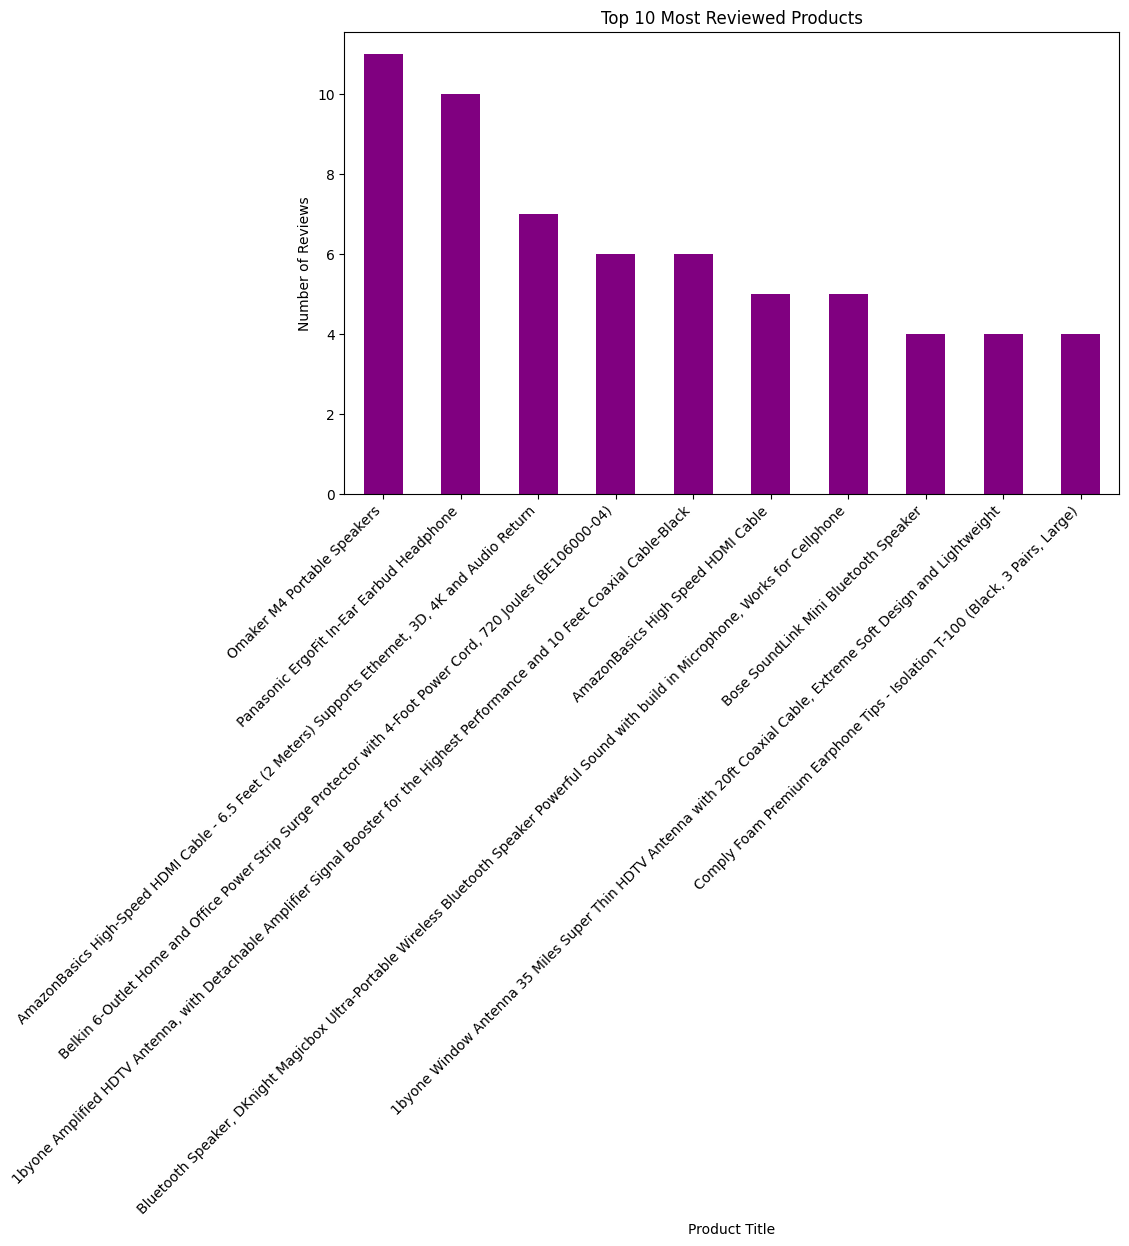


Missing Values:
product_id       0
product_title    0
star_rating      0
review_body      0
price            0
review_length    0
dtype: int64


In [4]:
# Basic info
print("Dataset Info:")
print(df.info())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# 1. Distribution of Star Ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='star_rating', data=df, palette='viridis')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

# 2. Distribution of Mock Prices
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=20, kde=True, color='blue')
plt.title('Distribution of Mock Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

# 3. Review Length Analysis
df['review_length'] = df['review_body'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 5))
sns.histplot(df['review_length'], bins=30, kde=True, color='green')
plt.title('Distribution of Review Lengths (Word Count)')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.show()

# 4. Top 10 Most Reviewed Products
top_products = df['product_title'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='purple')
plt.title('Top 10 Most Reviewed Products')
plt.xlabel('Product Title')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

# 5. Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

# <span style="color: darkblue;">Preprocess and Index Data</span>

After EDA, preprocess the data for RAG.

In [5]:
# Combine product title and review into a single text field
df['combined_text'] = df.apply(
    lambda row: f"Product: {row['product_title']} | Price: ${row['price']} | Rating: {row['star_rating']} | Review: {row['review_body']}", 
    axis=1
)

# Convert to LangChain Documents (Fixed: use row["combined_text"])
documents = [Document(page_content=row["combined_text"], metadata={"product_id": row["product_id"], "price": row["price"], "star_rating": row["star_rating"]}) 
             for _, row in df.iterrows()]

# Split text into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = text_splitter.split_documents(documents)

# Create embeddings and vector store
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_documents(split_docs, embedding_model)

print("Vector store created with", len(split_docs), "documents.")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vector store created with 1296 documents.


# <span style="color: darkblue;">Set Up the LLM</span>

In [6]:
# Set up a local LLM pipeline
llm_pipeline = pipeline("text-generation", model="distilgpt2", max_new_tokens=100)
llm = HuggingFacePipeline(pipeline=llm_pipeline)

# Define the RAG chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever(search_kwargs={"k": 2}),  # Retrieve top 2 matches
    return_source_documents=True
)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


# <span style="color: darkblue;">Query Handling and Recommendation</span>

Enhance the function to consider star ratings from EDA insights.

In [7]:
def get_recommendation(query):
    # Run the query through the RAG chain
    result = qa_chain({"query": query})
    retrieved_docs = result["source_documents"]
    generated_text = result["result"]
    
    # Debug: Print retrieved documents
    print("Retrieved Documents:")
    for i, doc in enumerate(retrieved_docs, 1):
        print(f"{i}. {doc.page_content[:100]}... | Price: ${doc.metadata['price']} | Rating: {doc.metadata['star_rating']}")
    
    # Filter by price and rating if specified
    max_price = None
    min_rating = 4  # Default to recommending 4+ star products
    if "under $" in query.lower():
        try:
            max_price = float(query.lower().split("under $")[1].split()[0])
            print(f"Filtering for max price: ${max_price}")
        except:
            pass
    if "rating" in query.lower():
        try:
            min_rating = float(query.lower().split("rating")[1].split()[0])
            print(f"Filtering for min rating: {min_rating}")
        except:
            pass
    
    # Extract relevant products
    recommended_products = []
    for doc in retrieved_docs:
        price = doc.metadata["price"]
        rating = doc.metadata["star_rating"]
        if (max_price is None or price <= max_price) and rating >= min_rating:
            recommended_products.append({
                "product_id": doc.metadata["product_id"],
                "text": doc.page_content
            })
    
    # Craft a response with more detail
    if recommended_products:
        response = "Here are my recommendations based on your request:\n"
        for i, prod in enumerate(recommended_products, 1):
            response += f"{i}. {prod['text']}\n"
        response += f"\nAdditional Info: {generated_text}"
    else:
        response = "Sorry, no products match your criteria.\n"
        response += "Possible reasons:\n"
        response += "- Retrieved items exceed the price limit or fall below the rating threshold.\n"
        response += "- The dataset subset may lack suitable laptops matching 'durable'.\n"
        response += "Check the retrieved documents above for details."
    
    return response

# Test the chatbot
query = "Suggest a durable laptop under $1000 with rating 4 or higher"
response = get_recommendation(query)
print(response)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Retrieved Documents:
1. Product: Ultratech 1270 12vDC 7000mAh Battery | Price: $767 | Rating: 5 | Review: as advertised... | Price: $767 | Rating: 5
2. Product: Belkin 6-Outlet Home and Office Power Strip Surge Protector with 4-Foot Power Cord, 720 Jou... | Price: $1370 | Rating: 5
Filtering for max price: $1000.0
Filtering for min rating: 4.0
Here are my recommendations based on your request:
1. Product: Ultratech 1270 12vDC 7000mAh Battery | Price: $767 | Rating: 5 | Review: as advertised

Additional Info: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Product: Ultratech 1270 12vDC 7000mAh Battery | Price: $767 | Rating: 5 | Review: as advertised

Product: Belkin 6-Outlet Home and Office Power Strip Surge Protector with 4-Foot Power Cord, 720 Joules (BE106000-04) | Price: $1370 | Rating: 5 | Review: This is a great value. Got a new computer and needed something fast. I

# <span style="color: darkblue;">Interactive Chatbot</span>

In [8]:
while True:
    user_input = input("Ask me for a recommendation (or type 'exit' to quit): ")
    if user_input.lower() == "exit":
        break
    print(get_recommendation(user_input))
    print("-" * 50)

Ask me for a recommendation (or type 'exit' to quit):  Should I use a smaller laptop? My laptop is much smaller


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Retrieved Documents:
1. Product: NEW Laptop AC Adapter/Power Supply/Charger+US Power Cord for Toshiba Satellite A105-S171 A1... | Price: $667 | Rating: 5
2. better than the internal speakers in my phone, tablets or even my laptop.<br /><br />If you have a n... | Price: $971 | Rating: 4
Here are my recommendations based on your request:
1. Product: NEW Laptop AC Adapter/Power Supply/Charger+US Power Cord for Toshiba Satellite A105-S171 A105-S2712 L25 L25-S119 L35-S2151 M35X l305-s5891 l305-s5944 l355-s7811 l355-s7817 m205-s4806 m305 m305-s4822 p205-s7804 p205d-s8802 u405-s2833 | Price: $667 | Rating: 5 | Review: Perfect fit. efficient.
2. better than the internal speakers in my phone, tablets or even my laptop.<br /><br />If you have a non-bluetooth device (and there are surprisingly many tablets in this day and age that are not equipped with bluetooth) this speaker is an inexpensive solution.

Additional Info: Use the following pieces of context to answer the question at the end. If yo

Ask me for a recommendation (or type 'exit' to quit):  exit


# <span style="color: darkblue;">Conclusion</span>

<p>This project <span style="color: green;">successfully demonstrates</span> the development of an <span style="color: blue;">E-commerce Product Recommendation Chatbot</span> using <span style="color: purple;">RAG</span>, effectively integrating retrieval and generation to provide <span style="color: orange;">tailored product suggestions</span>. By leveraging the <span style="color: teal;">Amazon Electronics Reviews dataset</span>, we explored real user feedback and simulated pricing to mimic an online shopping assistant. The implementation highlights the strengths of <span style="color: red;">LangChain and FAISS</span> for efficient document retrieval, though challenges like <span style="color: brown;">dataset subset limitations</span> and <span style="color: gray;">mock price variability</span> were encountered. Future enhancements could include incorporating <span style="color: gold;">real pricing data</span>, expanding the dataset scope, and fine-tuning the LLM for more <span style="color: pink;">coherent responses</span>, ultimately improving the chatbot’s utility in a production environment.</p>